In [1]:
# CSE545-SDG3-Matrix


In [2]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.window import *
from pyspark.sql.types import *


In [3]:
sc = pyspark.SparkContext(appName="SDG3")
sqlCtx = SQLContext(sc)
sc.version

'2.2.0'

In [1]:
df = sqlCtx.read.text("/VS14LINK.USNUMPUB")  #350 mb
#df = sqlCtx.read.text("/VS14LINK.USDENPUB") # 5gb
#df = sqlCtx.read.text("/*.*PUB") # both


NameError: name 'sqlCtx' is not defined

In [5]:
#- eading

In [5]:
# regular data frame after adding column metadata
ndf = df.select(
    df.value.substr(9,4).cast(IntegerType()).alias('Birth_Year'),
    df.value.substr(13,2).cast(IntegerType()).alias('Birth_Month'),
    df.value.substr(75,2).cast(IntegerType()).alias('Mothers_Age'),
    df.value.substr(84,1).alias('Mothers_Nativity'),
    df.value.substr(325,1).alias('InFertility_Treatment'),
    df.value.substr(326,1).alias('Fertility_Enhancing_Drugs'),
    df.value.substr(475,1).alias('Infant_Gender'),
    df.value.substr(299,3).cast(IntegerType()).alias('Delivery_Weight_lbs'),
    df.value.substr(492,2).cast(IntegerType()).alias('Gestational_Age_weeks'),
    df.value.substr(332,2).cast(IntegerType()).alias('Num_Prev_Cesareans'),
    df.value.substr(454,1).cast(IntegerType()).alias('Plurality'),
    df.value.substr(1368,4).alias('ICD10'),
    df.value.substr(568,1).cast(StringType()).alias('Infant_Living')
    
)

#ndf.na.replace('','0').show()
ndf.show()
#ndf.printSchema
#ndf.count()
#ndf

+----------+-----------+-----------+----------------+---------------------+-------------------------+-------------+-------------------+---------------------+------------------+---------+-----+-------------+
|Birth_Year|Birth_Month|Mothers_Age|Mothers_Nativity|InFertility_Treatment|Fertility_Enhancing_Drugs|Infant_Gender|Delivery_Weight_lbs|Gestational_Age_weeks|Num_Prev_Cesareans|Plurality|ICD10|Infant_Living|
+----------+-----------+-----------+----------------+---------------------+-------------------------+-------------+-------------------+---------------------+------------------+---------+-----+-------------+
|      2013|          7|         24|               1|                    N|                        X|            F|                233|                   10|                 0|        1| R99 |            Y|
|      2013|          9|         27|               1|                    N|                        X|            F|                230|                    8|               

In [6]:
# how many infants demised
ndf.filter(ndf['Infant_Living']=='N').count()

10186

In [7]:
ndf.filter(ndf['Birth_Year'] == 2014).count()

20413

In [8]:
def blank_as_null(x):
    return when(col(x) != ' ', col(x)).otherwise(np.nan)


In [9]:
# pandas data frame after adding column metadata

pndf = df.select(
    df.value.substr(9,4).cast(IntegerType()).alias('Birth_Year'),
    df.value.substr(13,2).cast(IntegerType()).alias('Birth_Month'),
    df.value.substr(75,2).cast(IntegerType()).alias('Mothers_Age'),
    df.value.substr(84,1).alias('Mothers_Nativity'),
    df.value.substr(325,1).alias('InFertility_Treatment'),
    df.value.substr(326,1).alias('Fertility_Enhancing_Drugs'),
    df.value.substr(475,1).alias('Infant_Gender'),
    df.value.substr(299,3).cast(IntegerType()).alias('Delivery_Weight_lbs'),
    df.value.substr(492,2).cast(IntegerType()).alias('Gestational_Age_weeks'),
    df.value.substr(332,2).cast(IntegerType()).alias('Num_Prev_Cesareans'),
    df.value.substr(454,1).cast(IntegerType()).alias('Plurality'),
    df.value.substr(1368,4).alias('ICD10'),
    df.value.substr(568,1).cast(StringType()).alias('Infant_Living')   
    
).withColumn("id", monotonically_increasing_id())

pndf.printSchema
pndf =pndf.na.fill({'Num_Prev_Cesareans': 0.0})
pndf = pndf.withColumn("Infant_Living", blank_as_null("Infant_Living"))

pndf = pndf.toPandas()
#pndf.replace("", np.nan, regex=True)
pndf.head(30)

,Birth_Year,Birth_Month,Mothers_Age,Mothers_Nativity,InFertility_Treatment,Fertility_Enhancing_Drugs,Infant_Gender,Delivery_Weight_lbs,Gestational_Age_weeks,Num_Prev_Cesareans,Plurality,ICD10,Infant_Living,id
0,2013,7,24,1,N,X,F,233.0,10,0,1,R99,Y,0
1,2013,9,27,1,N,X,F,230.0,8,1,1,R95,Y,1
2,2013,10,25,1,N,X,F,273.0,7,0,1,R99,Y,2
3,2013,10,24,1,N,X,F,157.0,6,0,1,R99,Y,3
4,2013,10,32,1,N,X,M,233.0,8,0,1,R99,Y,4
5,2013,11,29,1,N,X,F,193.0,8,0,1,G129,Y,5
6,2013,11,19,1,N,X,M,308.0,7,0,1,A419,Y,6
7,2013,12,28,1,N,X,M,138.0,4,0,1,W75,Y,7
8,2013,12,22,1,N,X,M,150.0,7,0,1,R95,Y,8
9,2013,12,22,1,N,X,M,156.0,2,0,1,P77,Y,9


In [10]:
# how many infants demised
pndf.filter(pndf['Infant_Living']=='N').count()

Series([], dtype: int64)

In [11]:
pndf.shape

(23085, 14)

In [12]:
#featureDf = ndf.withColumn("Delivery_Weight_gms", toInt(df['Delivery_Weight_lbs'])).select('Delivery_Weight_lbs')

In [13]:
#pndf[pd.isnull(pndf['Infant_Living'])]
#pndf[pndf.Infant_Living == None]
pndf.Infant_Living.unique()

array(['Y', 'NaN', 'U', 'N'], dtype=object)

In [14]:
#pndf.ICD10.unique()

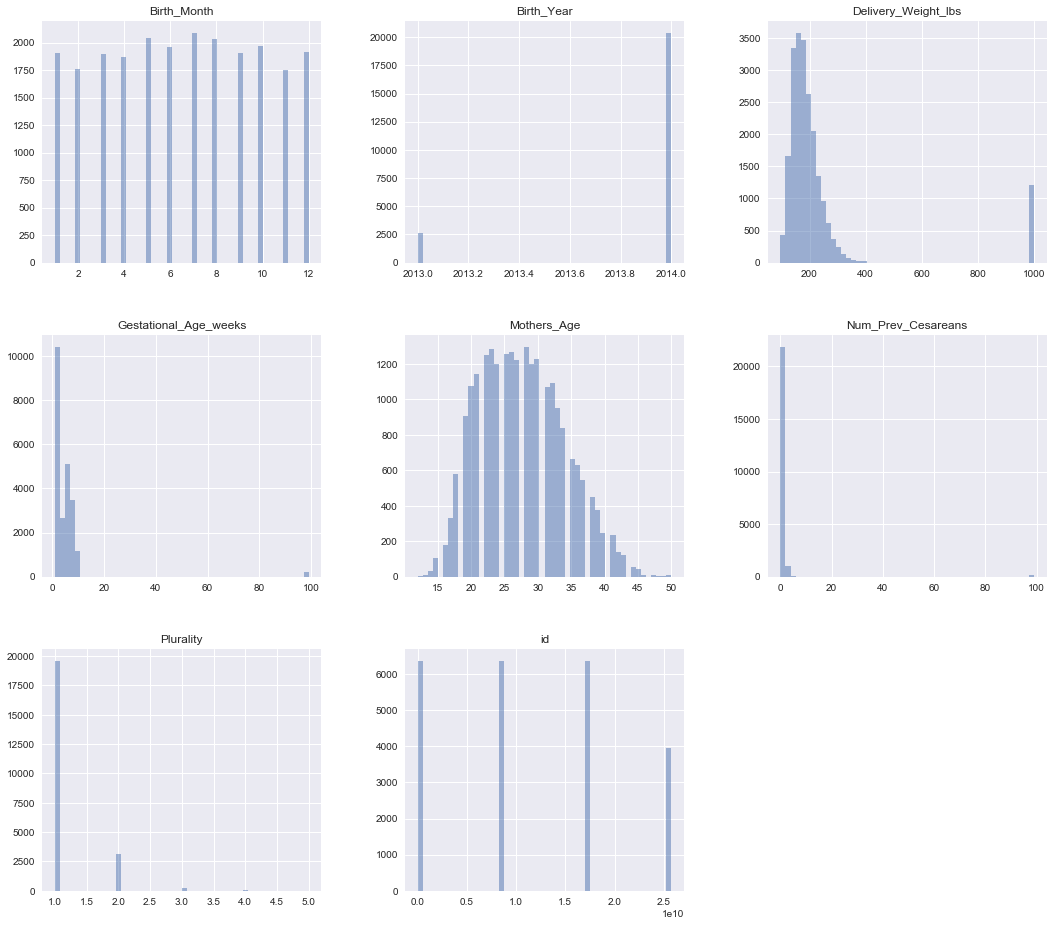

In [15]:
pndf.hist(figsize=(18, 16), alpha=0.5, bins=50)
plt.show()

In [16]:
pndf.describe()

,Birth_Year,Birth_Month,Mothers_Age,Delivery_Weight_lbs,Gestational_Age_weeks,Num_Prev_Cesareans,Plurality,id
count,23085.000000,23085.000000,23085.000000,22238.000000,23085.000000,23085.000000,23085.000000,2.308500e+04
mean,2013.884254,6.516049,27.650682,228.642369,4.917999,0.860559,1.167035,1.154255e+10
std,0.319927,3.404089,6.338831,190.750716,9.131393,8.089631,0.423998,9.096958e+09
min,2013.000000,1.000000,12.000000,96.000000,1.000000,0.000000,1.000000,0.000000e+00
25%,2014.000000,4.000000,23.000000,151.000000,2.000000,0.000000,1.000000,5.771000e+03
50%,2014.000000,7.000000,27.000000,179.000000,3.000000,0.000000,1.000000,8.589940e+09
75%,2014.000000,9.000000,32.000000,218.000000,6.000000,0.000000,1.000000,1.717987e+10
max,2014.000000,12.000000,50.000000,999.000000,99.000000,99.000000,5.000000,2.576981e+10


In [17]:
pndf['Infant_Living'] = pndf['Infant_Living'].fillna("U")
pndf['Infant_Living'] = pndf['Infant_Living'].map({"Y": 1, "N": 0, "U": -1})
#pndf['Infant_Living'] = 0
pndf.head(20)

,Birth_Year,Birth_Month,Mothers_Age,Mothers_Nativity,InFertility_Treatment,Fertility_Enhancing_Drugs,Infant_Gender,Delivery_Weight_lbs,Gestational_Age_weeks,Num_Prev_Cesareans,Plurality,ICD10,Infant_Living,id
0,2013,7,24,1,N,X,F,233.0,10,0,1,R99,1.0,0
1,2013,9,27,1,N,X,F,230.0,8,1,1,R95,1.0,1
2,2013,10,25,1,N,X,F,273.0,7,0,1,R99,1.0,2
3,2013,10,24,1,N,X,F,157.0,6,0,1,R99,1.0,3
4,2013,10,32,1,N,X,M,233.0,8,0,1,R99,1.0,4
5,2013,11,29,1,N,X,F,193.0,8,0,1,G129,1.0,5
6,2013,11,19,1,N,X,M,308.0,7,0,1,A419,1.0,6
7,2013,12,28,1,N,X,M,138.0,4,0,1,W75,1.0,7
8,2013,12,22,1,N,X,M,150.0,7,0,1,R95,1.0,8
9,2013,12,22,1,N,X,M,156.0,2,0,1,P77,1.0,9


In [18]:

pndf['Infant_Gender'] = pndf['Infant_Gender'].fillna("F")
pndf['Infant_Gender'] = pndf['Infant_Gender'].map({"F": 1,"M": 2})
pndf.head(20)

,Birth_Year,Birth_Month,Mothers_Age,Mothers_Nativity,InFertility_Treatment,Fertility_Enhancing_Drugs,Infant_Gender,Delivery_Weight_lbs,Gestational_Age_weeks,Num_Prev_Cesareans,Plurality,ICD10,Infant_Living,id
0,2013,7,24,1,N,X,1,233.0,10,0,1,R99,1.0,0
1,2013,9,27,1,N,X,1,230.0,8,1,1,R95,1.0,1
2,2013,10,25,1,N,X,1,273.0,7,0,1,R99,1.0,2
3,2013,10,24,1,N,X,1,157.0,6,0,1,R99,1.0,3
4,2013,10,32,1,N,X,2,233.0,8,0,1,R99,1.0,4
5,2013,11,29,1,N,X,1,193.0,8,0,1,G129,1.0,5
6,2013,11,19,1,N,X,2,308.0,7,0,1,A419,1.0,6
7,2013,12,28,1,N,X,2,138.0,4,0,1,W75,1.0,7
8,2013,12,22,1,N,X,2,150.0,7,0,1,R95,1.0,8
9,2013,12,22,1,N,X,2,156.0,2,0,1,P77,1.0,9


In [19]:
#find the largest cause of fetal death in 2014
# P072 is 'Extreme immaturity of newborn, unspecified weeks of gestation'
icds = pndf.groupby('ICD10')
for name, groupdf in icds:
    if groupdf['ICD10'].count() == icds.size().max():
        print(name," -- ",groupdf['ICD10'].count())

P072  --  3162


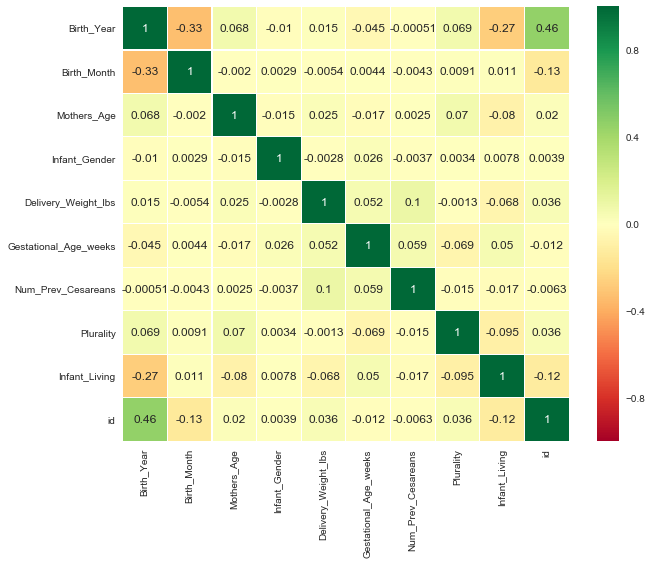

In [20]:


pndf_numeric = pndf[["Birth_Year", "Birth_Month", "Mothers_Age",
                    "Delivery_Weight_lbs", "Gestational_Age_weeks", "Num_Prev_Cesareans",
                    "Plurality", "id"]]

# calculate the correlation matrix

#sns.heatmap(pndf_numeric.corr())
sns.heatmap(pndf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()
fig.savefig('Correlation.png') 

In [21]:
grpicds = icds.size()
grpicds.head()

ICD10
A021    2
A022    2
A047    2
A049    1
A080    1
dtype: int64

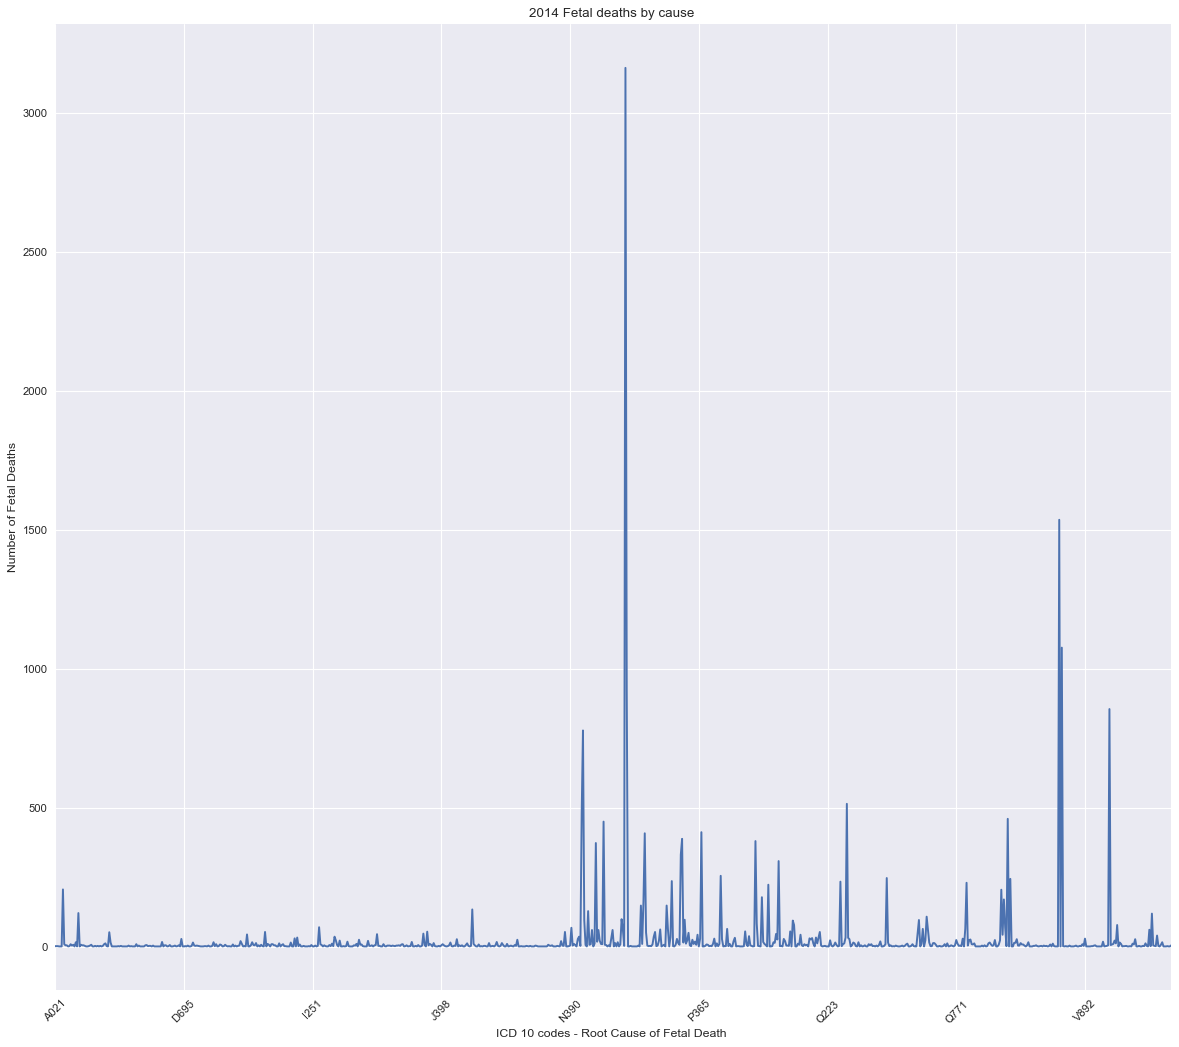

In [22]:
#plot of all root cause of fetal death(x-axis) and #deaths (y-axis)
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.title("2014 Fetal deaths by cause ")
subplt = fig.add_subplot(1,1,1)
grpicds.plot(rot=45,grid=True ) #ax=subplt, logy=True

subplt.set_ylabel("Number of Fetal Deaths")
subplt.set_xlabel("ICD 10 codes - Root Cause of Fetal Death ")

plt.show()
fig.savefig('LeadingFetalCOD2014.png') 